In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dpk import model_objs, koopman_probabilistic
import datetime as dt
import xarray as xr
sns.set_theme()

In [180]:
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

[ Using Seed :  633  ]


In [181]:
K = 200
name = "2018-19_gaussianOmega"
V = np.load(f"ristretto/{name}_rank{K}V.npy")
rank = 50
V = V[:, :rank]

In [182]:
scales = V.std(axis=0, keepdims=True)
x = V / scales

In [184]:
periods = np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # hours
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
# param_str = f"NormalNLL_{rank}_{l1width}_{l2width}_{32}_{900}_{seed}_{wd}_{lrt}"
model = model_objs.NormalNLL(x_dim=rank, num_freqs=3, n=l1width, n2=l2width)
# model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

In [185]:
k = koopman_probabilistic.KoopmanProb(model, batch_size=32, device="cpu")
k.init_periods(periods)


In [186]:
total_iters = 0

In [195]:
iters = 300
total_iters += iters
k.fit(x, iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.23172188
Iteration  1
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.2316566
Iteration  2
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.2315625
Iteration  3
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.23163193
Iteration  4
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 87

KeyboardInterrupt: 

In [196]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24

H = V.shape[0] + T
params = k.predict(H)
params = model.rescale(loc=0, scale=scales, params=params)
mean_hat = model.mean(params)
std_hat = model.std(params)

In [ ]:
param_str = f"NormalNLL_{rank}_{l1width}_{l2width}_{k.batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

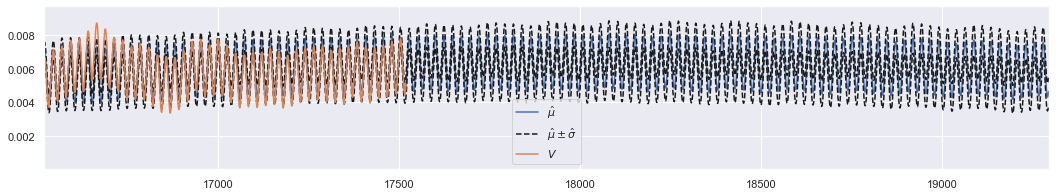

In [ ]:
i = 0
plt.figure(figsize=(18, 3))
plt.plot(mean_hat[:, i], label="$\hat \mu$")
plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
plt.plot(V[:H, i], label="$V$")
plt.xlim([V.shape[0] - 1000, H])
plt.legend()

ValueError: num must be 1 <= num <= 10, not 11

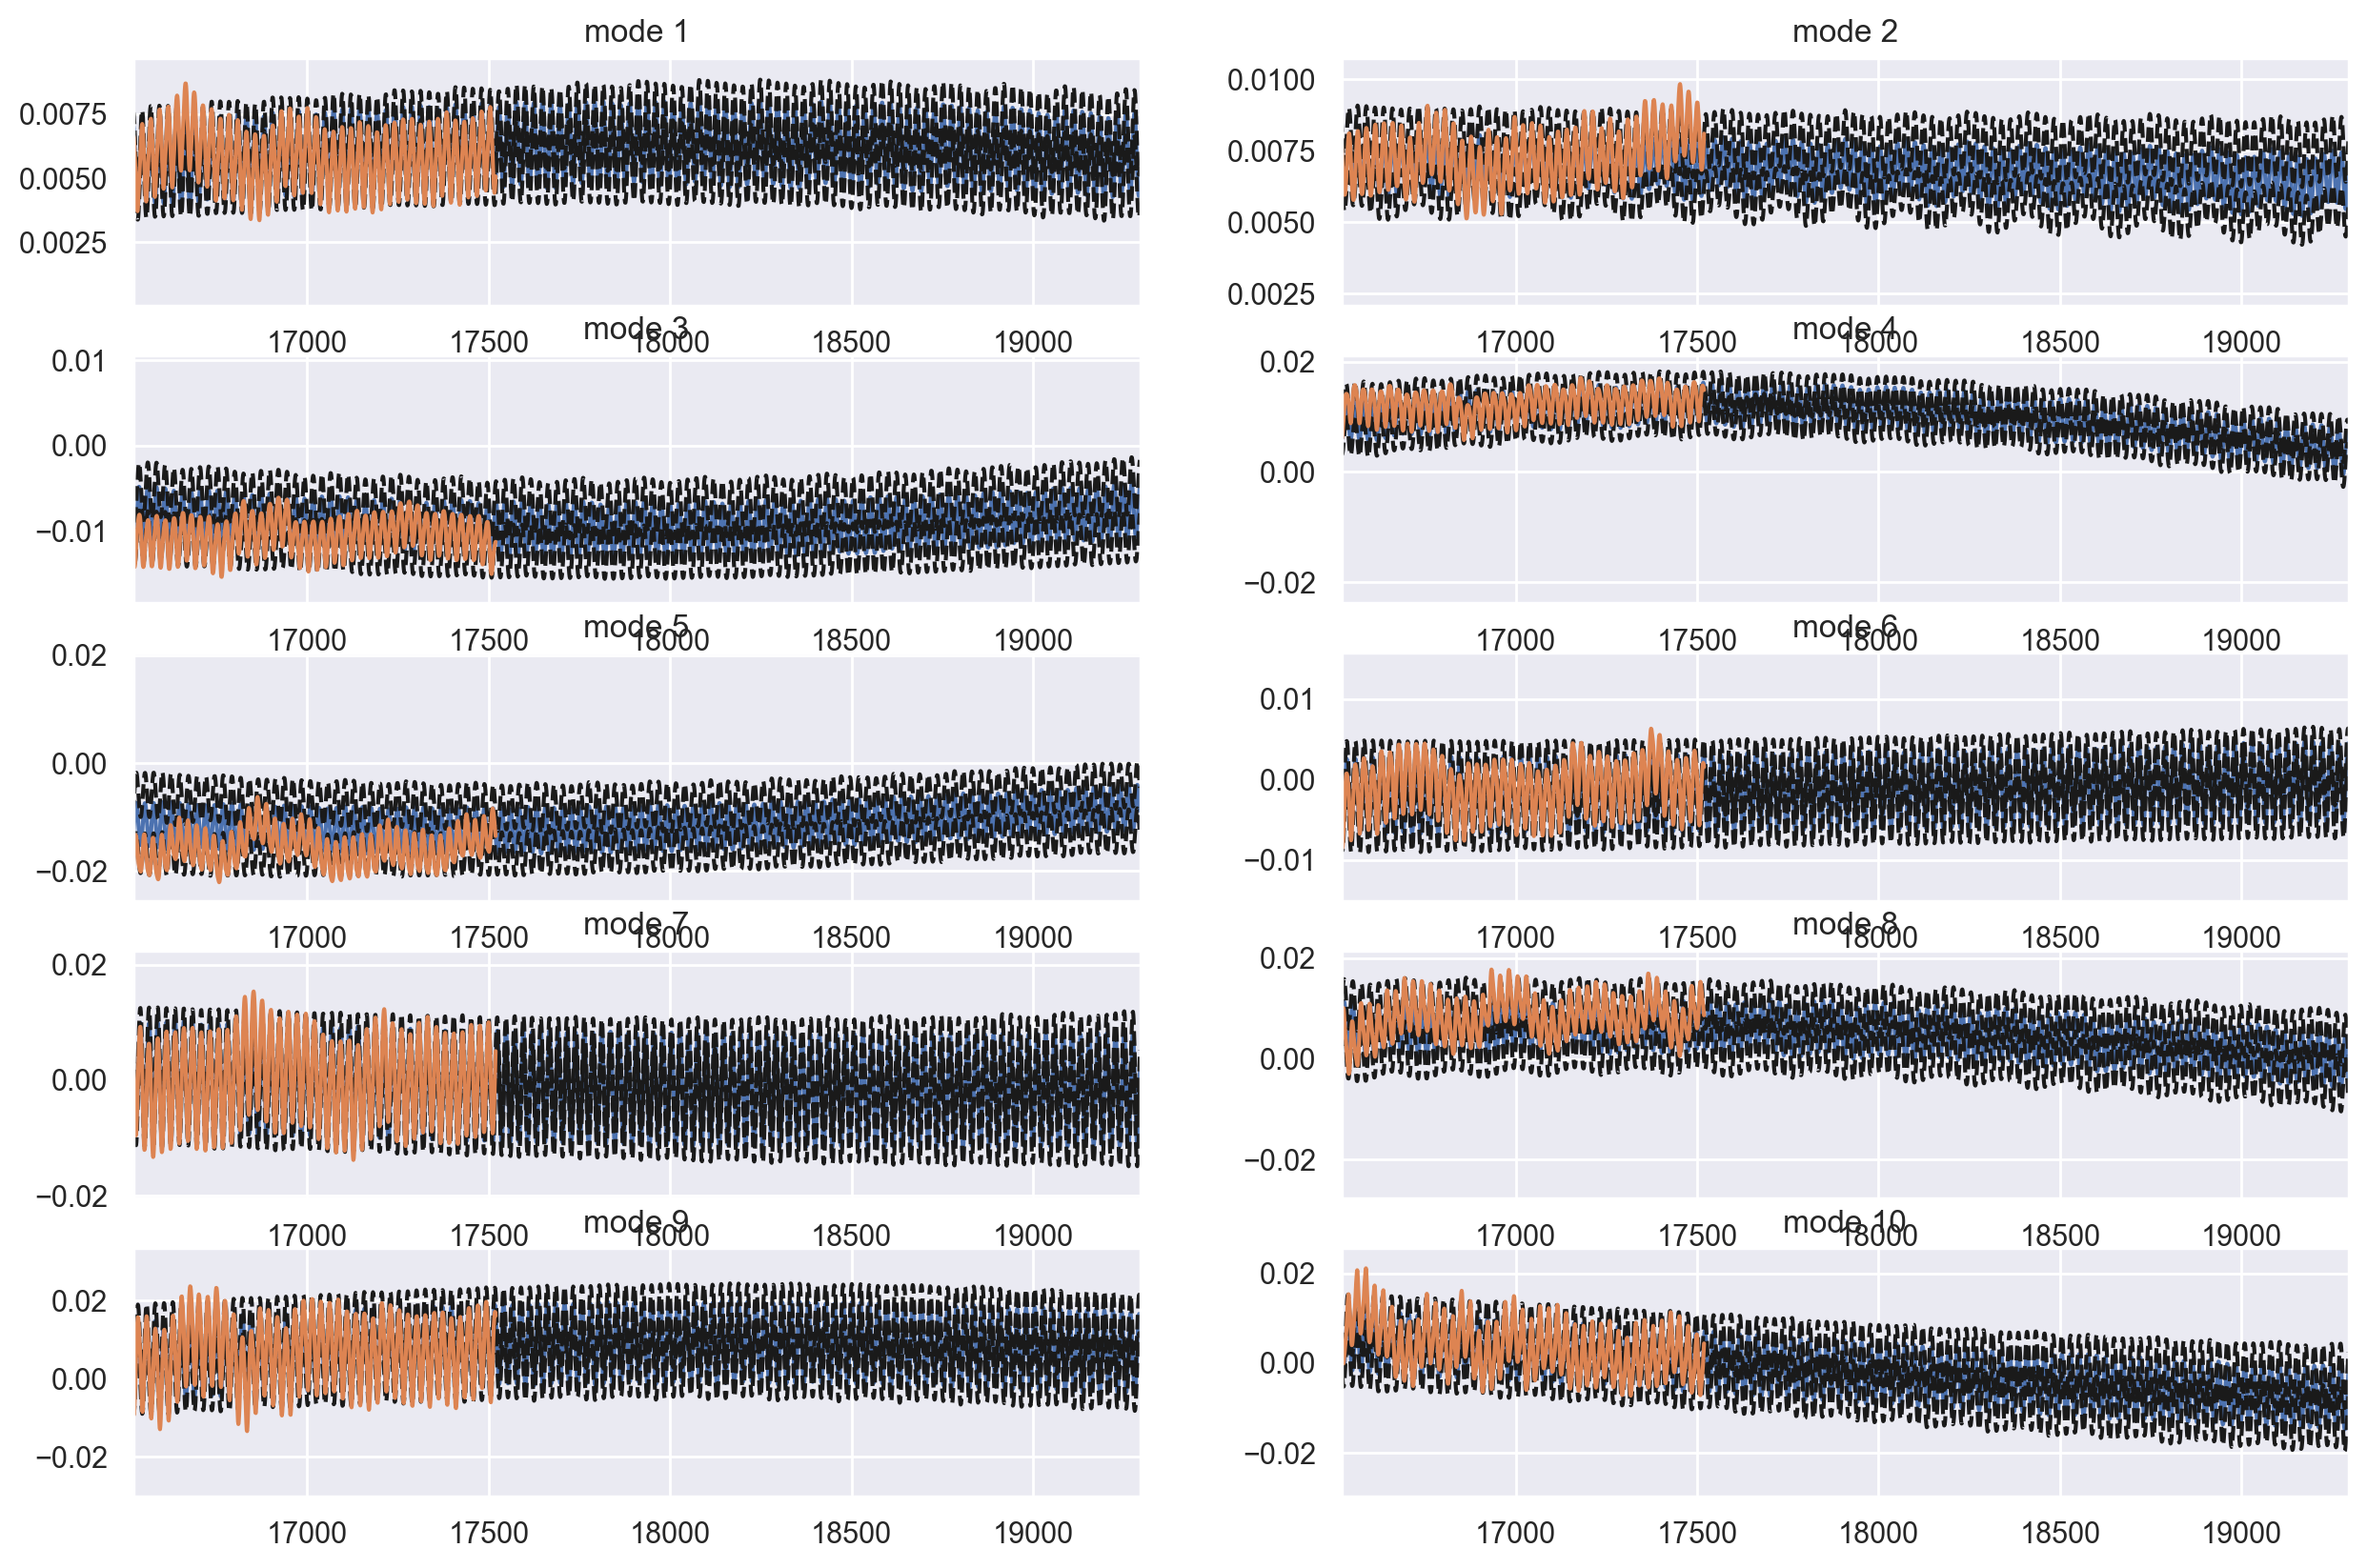

In [ ]:
plt.subplots(5, 2, figsize=(15, 10), dpi=200)
start = 0
for i in range(start, start + rank):
    plt.subplot(5, 2, i + 1 - start)
    plt.title(f"mode {i + 1}")
    plt.plot(mean_hat[:, i], label="$\hat \mu$")
    plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
    plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
    plt.plot(V[:H, i], label="$V$")
    plt.xlim([V.shape[0] - 1000, H])
plt.tight_layout()
plt.legend()
plt.show()

# Compute MSE of central estimate

In [ ]:
U = np.load(f"D:/atmo-chem/{name}_rank{K}U.npy")
spatial_means = np.load(f"ristretto/{name}_spatial_means.npy")
s = np.load(f"ristretto/{name}_rank{K}sigmas.npy")

In [197]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24

MSE = 0

t = V.shape[0]
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    
    # reconstruct A
    prediction = U[:, :rank] @ np.diag(s[:rank]) @ mean_hat[t:t + A.shape[1], :].T
    this_mse = ((prediction - A)**2)
    MSE += np.sum(this_mse / (A.shape[0] * T))
    print("\tMSE:", this_mse.mean())

    current_date += increment
    t += A.shape[1]

working on 2020-01-01 00:00:00
	MSE: 0.539544951378858
working on 2020-01-02 00:00:00
	MSE: 0.6523547773276767
working on 2020-01-03 00:00:00
	MSE: 0.6396766751182578
working on 2020-01-04 00:00:00
	MSE: 0.546979207568119
working on 2020-01-05 00:00:00
	MSE: 0.5210442851397775
working on 2020-01-06 00:00:00
	MSE: 0.48630886484320335
working on 2020-01-07 00:00:00
	MSE: 0.4529018935682116
working on 2020-01-08 00:00:00
	MSE: 0.46978872330241767
working on 2020-01-09 00:00:00
	MSE: 0.4461420984791668
working on 2020-01-10 00:00:00
	MSE: 0.44558426595840156
working on 2020-01-11 00:00:00
	MSE: 0.5029532917750956
working on 2020-01-12 00:00:00
	MSE: 0.5292459624306269
working on 2020-01-13 00:00:00
	MSE: 0.5165605355038244
working on 2020-01-14 00:00:00
	MSE: 0.5233673947516512
working on 2020-01-15 00:00:00
	MSE: 0.5232023318564859
working on 2020-01-16 00:00:00
	MSE: 0.48173997811611946
working on 2020-01-17 00:00:00
	MSE: 0.47248251996523805
working on 2020-01-18 00:00:00
	MSE: 0.443313

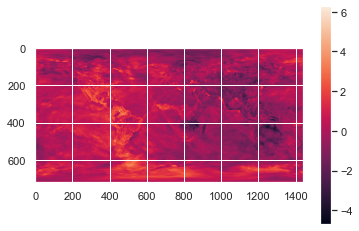

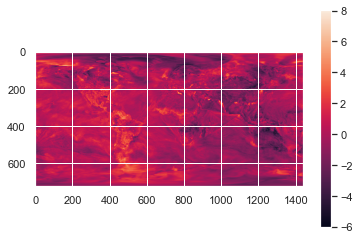

In [198]:
plt.imshow(prediction.reshape((721, 1440, 24))[::-1, :, 5])
plt.colorbar()
plt.show()
plt.imshow(A.reshape((721, 1440, 24))[::-1, :, 5])
plt.colorbar()
plt.show()

In [199]:
print("rank:", rank, "MSE:", MSE)

rank: 50 MSE: 0.5755321660206213


In [ ]:
print("rank:", rank, "MSE:", MSE)

rank: 50 MSE: 0.5759224670516686


In [ ]:
print("rank:", rank, "MSE:", MSE)

rank: 10 MSE: 0.6489049180026171


In [164]:
print("rank:", rank, "MSE:", MSE)

rank: 20 MSE: 0.5945246015733084


In [147]:
print("rank:", rank, "MSE:", MSE)

rank: 5 MSE: 0.7064405227162223


In [135]:
print("rank:", rank, "MSE:", MSE)

rank: 4 MSE: 0.7701405817278341


In [123]:
print("rank:", rank, "MSE:", MSE)

rank: 3 MSE: 0.8346050727588257
